 -----------------------------------------------------------------------------------------------------------------------

GRUPO: PL3 - 6

Magda Costa - up202207036

Rafael Pacheco - up202206258

Sofia Machado - up202207203

 -----------------------------------------------------------------------------------------------------------------------

# Connect Four: The Game


## Índice  <a name = "indice"></a>
1. [Introdução](#introdução)
2. [Formulação do problema](#problema)
3. [Implementação do Jogo](#jogo)
4. [Heurísticas](#heuristicas)
    - [Heurística 1](#heuristica_1)
    - [Heurística 2](#heuristica_2)
    - [Heurística 3](#heuristica_3)
5. [Algoritmos](#algoritmos)
    - [A Star](#astar)
    - [Monte Carlo Tree Search](#mcts)
        - [PROBLEMA 1: Nós Terminais](#mcts_p1)
        - [PROBLEMA 2: Qual o valor da constante do UCB?](#mcts_p2)
        - [PROBLEMA 3: 4.2 é de facto o melhor valor para a constante?](#mcts_p3)
    - [Minimax](#minimax)
        - [PROBLEMA 1: Vitória Desperdiçada](#minimax_p1)
6. [Interface](#interface)
    - [Menu](#menu_terminal)
    - [Modos de Jogo](#modos_terminal)
    - [Iniciar Jogo no Terminal](#start_terminal)
7. [Testes](#testes)
    - [Pruning VS sem pruning](#pruning_vs)
    - [Heurística 1 VS Heurística 2](#heuristicas_vs)
    - [Heurística 1 VS Heurística 3](#heuristicas_vs2)
    - [Monte Carlo Tree Search Variação de Nós](#mcts_nos)
    - [Monte Carlo Tree Search VS A Star](#mcts_vs_astar)
    - [Monte Carlo Tree Search VS Minimax](#mcts_vs_minimax)

8. [Conclusões dos Algoritmos](#comp_alg)
9. [Conclusão](#conclusão)

 -----------------------------------------------------------------------------------------------------------------------

## Introdução <a name = "introdução"></a>
[[voltar ao índice]](#indice)




O Connect Four, também conhecido como Quatro em Linha, é um jogo que implica a disposição de peças numa grelha vertical de sete colunas. O vencedor é aquele que consegue alinhar quatro peças da mesma cor, tanto na vertical, horizontal ou diagonal.

Este trabalho consiste na implementação de algoritmos que permitam resolver o jogo, com ênfase na eficiência e na capacidade de tomada de decisão estratégica. Através deste será possível testar os algoritmos desenvolvidos, A* (A Star) e Monte Carlo Tree Search (MCTS), o que nos permite comparar e avaliar a eficácia e aplicabilidade de cada um. Para além destes, decidimos também implementar o algoritmo Minimax.

Para realizar este trabalho foram utilizadas as seguintes bibliotecas:

In [1]:
from copy import deepcopy
import math
import random
import time
from time import perf_counter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

[[voltar a 'Introdução']](#introdução)

 -----------------------------------------------------------------------------------------------------------------------

## Formulação do Problema <a name = "problema"></a>
[[voltar ao índice]](#indice)


De modo a compreender como desenvolver o código que dá vida ao Connect Four, começamos por formular o problema e por entender quais as medidas necessárias a tomar. Tendo concluido o seguinte:

**Estado Inicial:** O estado inicial corresponde à configuração inicial do jogo, onde ainda não foi jogada nenhuma peça.

**Ações Possíveis:** As ações possíveis correspondem à escolha de uma coluna na qual o jogador atual pode colocar uma peça. Em cada jogada, este pode escolher qualquer uma das sete colunas disponíveis desde que ainda haja espaço para colocar a peça.

**Função Sucessora:** A função sucessora determina o estado após a execução de uma ação num certo estado. Após o jogador escolher uma coluna para jogar, a função sucessora atualiza o estado do tabuleiro, colocando uma peça nova na posição adequada.

**Teste de Objetivo:** O teste de objetivo verifica se o jogo chegou a uma condição de vitória ou empate. O jogo termina quando um jogador consegue alinhar consecutivamente quatro das suas peças na horizontal, vertical ou diagonal, ou quando todas as células do tabuleiro se encontram preenchidas, não sendo portanto possivel um jogador ganhar.

**Função de Custo:** A função de custo atribui um valor a cada estado do jogo, refletindo a qualidade da posição atual e influenciando as decisões do algoritmo. Sendo esta referida posteriormente.

[[voltar a 'Formulação do Problema']](#problema)

 -----------------------------------------------------------------------------------------------------------------------

## Implementação do Jogo <a name = "jogo"></a>
[[voltar ao índice]](#indice)

Começamos por fazer a implementação básica do jogo onde dois jogadores, que usam as peças 'X' e 'O', competem para formar primeiro uma sequência de quatro peças iguais, num tabuleiro com 6 linhas e 7 colunas.

Para tal, criámos a classe ConnectFour, que inicializa com a criação de um tabuleiro marcado inicialmente com hífens para representar espaços vazios. Esta classe mantém um registo dos movimentos possíveis em cada coluna e um indicador para o fim do jogo.

As funções desta classe incluem a visualização do tabuleiro, a alternância entre os jogadores, e a atualização dos movimentos disponíveis e do tabuleiro após cada jogada.

Desenvolvemos ainda uma função para verificar se é possível executar uma jogada e outra para avaliar se o jogador atual venceu. Por fim, combinámos todas as funções que permitem que o jogo decorra até um jogador ganhar ou até que todas as jogadas sejam esgotadas, resultando num empate.

In [2]:
# Classe que cria o jogo e o gere
class ConnectFour:
    def __init__(self):
        self.board = [['-' for _ in range(7)] for _ in range(6)]    # tabuleiro
        self.current_player = 'X'   # se for 'X' é um jogador, se for 'O' é outro
        self.moves_left = 42    # número de jogadas que faltam fazer
        self.pm = {0: [5,0], 1: [5,1], 2: [5,2], 3: [5,3], 4: [5,4], 5: [5,5], 6: [5,6]}    # dicionário que guarda os movimentos possiveis, ou seja, onde a peça pode cair 
        self.e = False  # Indica se o jogo acabou ou não ("end")

    # dá print ao estado atual do tabuleiro
    def print_board(self):
        for row in self.board:
            print("| " + " | ".join(row) + " |")
        print("=" * 29)
        print("  0   1   2   3   4   5   6")

    # muda do jogador1 para o jogador2 e vice-versa
    def change_player(self):
        self.current_player = 'O' if self.current_player == 'X' else 'X'

    # atualiza os novos possiveis movimentos, consoante a coluna onde foi feita a última jogada
    def update_pm(self, column):
        y, x = self.pm[column]
        self.pm[column] = [y-1, x]

    # introduz a nova jogada no tabuleiro
    def update_board(self, y, x):
        self.board[y][x] = self.current_player

    # vê se o movimento é possivel, se for atualiza o jogo
    def make_move(self, column, player = True):
        if not 0 <= column < 7: 
            print("\nColuna inválida. Tente novamente.")
            return False
        
        if self.pm[column][0] == -1:  # não é possivel colocar mais peças nessa coluna
            if player:
                print("\nColuna cheia. Tente novamente.")
            return False

        # movimento é possivel 
        y, x = self.pm[column]
        self.update_board(y, x)  # introduz o movimento no tabuleiro
        self.update_pm(column)  # atualiza as novas jogadas possiveis
        self.moves_left -= 1  # retira-se o movimento
        return True

    # vê se o jogador venceu o jogo
    def check_win(self):
        # Verifica a horizontal
        for row in range(6):
            for col in range(4):
                if all(self.board[row][col + i] == self.current_player for i in range(4)):
                    return True
        # Verifica a vertical
        for row in range(3):
            for col in range(7):
                if all(self.board[row + i][col] == self.current_player for i in range(4)):
                    return True
        # Vê as diagonais com sentido da esquerda para a direita
        for row in range(3):
            for col in range(4):
                # com declive negativo
                if all(self.board[row + i][col + i] == self.current_player for i in range(4)):
                    return True
                # com declive positivo
                if all(self.board[row + i][col + 3 - i] == self.current_player for i in range(4)):
                    return True
        return False
    
    # função que gere o jogo
    def make_play(self, column, player=True):
        if self.make_move(column, player):  # se o movimento foi possivel
            if player: self.print_board()  # imprime a jogada feita
            if self.moves_left == 0:    # vê se o jogo resultou em empate
                if player: print("\nEmpate!") # caso o jogo não tenha acabado e as jogadas se tenham esgotado
                self.e = True
                return
            if self.check_win():    # vê se o jogo foi ganho
                if player: print(f"\nO jogador {self.current_player} ganhou!")
                self.e = True
                return
            self.change_player() # a jogada foi feita e o jogo não acabou, mudamos o jogador
            return True
        return False

[[voltar a 'Implementação do Jogo']](#jogo)

 -----------------------------------------------------------------------------------------------------------------------

## Heurísticas <a name = "heuristicas"></a>
[[voltar ao índice]](#indice)

Para este trabalho foram desenvolvidas três heuristicas com o objetivo de determinar qual o melhor método de avaliação para cada jogada.

### Heurística 1 <a name = "heuristica_1"></a>
[[voltar ao índice]](#indice)

Esta heurística avalia todos os conjuntos de quatro peças que são possiveis formar que contenham a peça que acaba de ser colocada, regendo-se pelas seguintes regras para a atribuição de pontos:

- Uma vitória para o jogador X tem um valor de +512.
- Uma vitória para o jogador O tem um valor de -512.
- Um empate tem um valor de 0.
- Para as posições intermediárias, consideramos todas as combinações possíveis  de quatro peças alinhadas (horizontal, vertical ou diagonal) e atribuímos os seguintes valores:

    - -50 para três peças de O sem X.
    
    - -10 para duas peças de O sem X.
    
    - -1 para uma peça de O sem X.
     
    - 0 para nenhuma peça ou uma mistura de peças de X e O.
     
    - 1 para uma peça de X sem O.
     
    - 10 para duas peças de X sem O.
     
    - 50 para três peças de X sem O.
- Para além disso, é adicionado um bónus dependendo de quem realiza a jogada:

   - +16 para X.
   - -16 para O.
   
A função evaluate_move() calcula a pontuação final se uma peça for colocada numa determinada posição, levando em consideração todas as linhas, colunas e diagonais que passam por essa posição numa janela de 4 posições.

Para isso, percorremos todas as direções possíveis relativamente à posição da peça e avaliamos os segmentos de quatro peças que se formam em todas as direções possíveis. A pontuação de cada segmento é calculada utilizando a função evaluate_segment(), que atribui uma pontuação de acordo com a presença de peças do jogador ou do adversário.

Por fim, somamos a pontuação de todos os segmentos avaliados e adicionamos um bónus de movimento, a cada jogador. 

In [3]:
# esta função avalia o tabuleior todo, não só onde foi colocada a peça
def evaluate_move(y, x, board, player_token):
    score = 0   # vai guardar a pontuação final se colocarmos a peça naquela posição
    
    for i in range (4):
        # Horizontais (esquerda para direita)
        if 0 <= x + i - 3 <= 3:
            segment = [board[y][x+i-3+j] for j in range(4)] 
            score += evaluate_segment(segment, player_token)
        # Verticais (cima para baixo)
        if 0 <= y + i - 3 <= 2:
            segment = [board[y+i-3+j][x] for j in range(4)]
            score += evaluate_segment(segment, player_token)
        # Diagonal com sentido positivo (baixo para cima)
        if 3 <= y - i + 3 <= 5 and 0 <= x + i - 3 <= 3:
            segment = [board[y-i-3-j][x+i-3+j] for j in range(4)]
            score += evaluate_segment(segment, player_token)
        # Diagonal com sentido negativo (cima para baixo)
        if 0 <= y + i - 3 <= 2 and 0 <= x + i - 3 <= 3:
            segment = [board[y+i-3+j][x+i-3+j] for j in range(4)]
            score += evaluate_segment(segment, player_token)

    move_bonus = 16 if player_token == 'X' else -16
    return score + move_bonus

# atribui a pontuação ao segmento de 4 de acordo com a heuristica
def evaluate_segment(segment, player_token):
    numO=segment.count('O')
    numX=segment.count('X')
    pts={0:0, 1:1, 2:10, 3:50, 4:512}
    if (numO==numX==0): return 0       # Segmento vazio (mais aplicável para segunda heurística)
    elif (numO==0): return pts[numX]   # Se não houver peças 'O'
    elif (numX==0): return -pts[numO]    # Se não houver peças 'X' 
    return 0      # Mistura de peças no segmento

### Heurística 2 <a name = "heuristica_2"></a>
[[voltar a Heurísticas]](#heuristicas)

Numa tentativa de melhorar a eficiência e capacidade de decisão dos algoritmos, especialmente do minimax, implementámos também uma heurística que segue o princípio da heurística anterior, mas que se foca em analisar todos os segmentos de 4 peças possíveis do tabuleiro inteiro.

Esta heurística não requer a posição da última peça colocada, e é avaliada também de forma diferente para averiguar se isso implicaria uma melhoria na escolha de peças vencedoras, o que poderia ser vantajoso para o algoritmo minimax.

In [4]:
def new_evaluation(board, ai_piece):
    score = 0   # vai guardar a pontuação final se colocarmos a peça naquela posição
    
    # Horizontais (esquerda para direita)
    for y in range(6): 
        for x in range(4):  
            segment = [board[y][x + i] for i in range(4)] 
            score += evaluate_segment_minimax(segment)

    # Verticais (cima para baixo)
    for x in range(7):  
        for y in range(3):  
            segment = [board[y + i][x] for i in range(4)]
            score += evaluate_segment_minimax(segment)

    # Diagonais com sentido positivo (baixo para cima)
    for y in range(3): 
        for x in range(4):  
            segment = [board[y + i][x + i] for i in range(4)]
            score += evaluate_segment_minimax(segment)

    # Diagonais com sentido negativo (cima para baixo)
    for y in range(3):  
        for x in range(4): 
            segment = [board[y + i][x + 3 - i] for i in range(4)]
            score += evaluate_segment_minimax(segment)

    move_bonus = 16 if ai_piece == 'X' else -16
    return score + move_bonus


def evaluate_segment_minimax(segment):
    numO=segment.count('O')
    numX=segment.count('X')
    pts={0:0, 1:1, 2:10, 3:50, 4:100000000000000}  # Vitórias implicam uma mudança de pontuação muito grande
    if (numO==numX==0): return 0
    elif (numO==0): return pts[numX]   # Se não houver peças 'O'
    elif (numX==0): return -pts[numO]    # Se não houver peças 'X' 
    return 0

### Heurística 3 <a name = "heuristica_3"></a>
[[voltar a Heurísticas]](#heuristicas)

Esta heurística foi criada após um resultado obtido no capítulo 7, 'Testes', e é uma combinação da leitura de tabuleiro da heurística 2 com o sistema de pontuação da heurística 1.

Isto porque o algoritmo com o sistema de análise de tabuleiro 2 venceu em todos os jogos ao sistema 1, e decidimos averiguar se era essa a razão pela qual existia uma diferença tão grande a nível de desempenho com a criação desta terceira heurística, da seguinte forma:

In [5]:
# pesquisa no tabuleiro da Heurística 1
def best_evaluation(board, ai_piece):
    score = 0   # vai guardar a pontuação final se colocarmos a peça naquela posição
    
    # Horizontais (esquerda para direita)
    for y in range(6): 
        for x in range(4):  
            segment = [board[y][x + i] for i in range(4)] 
            score += evaluate_segment(segment,ai_piece)

    # Verticais (cima para baixo)
    for x in range(7):  
        for y in range(3):  
            segment = [board[y + i][x] for i in range(4)]
            score += evaluate_segment(segment,ai_piece)

    # Diagonais com sentido positivo (baixo para cima)
    for y in range(3): 
        for x in range(4):  
            segment = [board[y + i][x + i] for i in range(4)]
            score += evaluate_segment(segment,ai_piece)

    # Diagonais com sentido negativo (cima para baixo)
    for y in range(3):  
        for x in range(4): 
            segment = [board[y + i][x + 3 - i] for i in range(4)]
            score += evaluate_segment(segment,ai_piece)

    move_bonus = 16 if ai_piece == 'X' else -16
    return score + move_bonus


[[voltar a 'Heuristicas']](#heuristicas)

 -----------------------------------------------------------------------------------------------------------------------

## Algoritmos <a name = "algoritmos"></a>
[[voltar ao índice]](#indice)

Para a realização deste trabalho foram implementados três algoritmos de inteligência artificial: A Star, Monte Carlo Tree Search e Minimax.

### A Star<a name = "astar"></a>
[[voltar a Algoritmos]](#algoritmos)

No contexto do jogo em análise, a classe Astar incorpora o algoritmo A Star que tem como objetivo decidir qual a melhor jogada que o computador deve fazer. Mais especificamente, a função make_move() determina qual movimento deve executar num dado estado do jogo.

Este algoritmo é utilizado para avaliar as opções de jogo disponíveis, tendo em conta a disposição atual do tabuleiro, e para atribuir um valor a cada jogada com base na heurística. A função choose_best_move() é então responsável por escolher a melhor jogada entre as possíveis, utilizando o valor calculado pelo A Star como critério de seleção.

Na prática, o A Star vai escolher a próxima jogada priorizando o nó na lista de nós a serem explorados que tem o menor valor de custo total, conforme calculado pela função de custo do algoritmo. 

In [6]:
class Astar():
    def __init__(self, game):
        self.g = game   # guarda o estado em que o jogo chega

    def choose_best_move(self, p):
        ans = []
        if self.g.current_player == 'X':
            max_value = max(p.values())   # calcula o maior valor do dicionário
            for col in p:
                if p[col] == max_value:
                    ans.append(col)
        else:
            min_value = min(p.values())   # calcula o maior valor do dicionário
            for col in p:
                if p[col] == min_value:
                    ans.append(col)            

        return random.choice(ans)
    

    def get_points(self):
        pm = self.g.pm
        player = self.g.current_player
        points = {}     # Índices das pontuações correspondem ao número da coluna onde se joga
        for col in pm:
            y, x = pm[col]  # guarda as coordenadas da jogada
            new_game = deepcopy(self.g) # precisamos de criar 'novos' jogos para pudermos analizar as jogadas
            if new_game.make_move(col): # O movimento pode são ser possivel (coluna cheia)
                points[col] = evaluate_move(y, x, new_game.board, player)

        return points


    def choose_move(self):
        points = self.get_points()  # calcula os pontos para cada jogada possivel
        best_move = self.choose_best_move(points) # entre as jogadas possiveis escolhe a melhor
        return best_move

### Monte Carlo Tree Search<a name = "mcts"></a>
[[voltar a Algoritmos]](#algoritmos)

Neste algoritmo, a classe Node é utilizada para representar os nós da árvore de pesquisa. Cada nó guarda informações sobre o estado do jogo, o jogador que realizou a jogada para deixar o estado assim, o nó pai, os nós filhos, o número de visitas, o número de vitórias, a jogada que levou a esse estado, uma lista que contém todas as jogadas possiveis a realizar e o número limite de nós a serem expandidos.

A classe MCTS implementa o algoritmo Monte Carlo Tree Search. A função choose_move_iter() é responsável por escolher a melhor jogada possível para o jogador atual a partir de um determinado número de iterações do algoritmo. Durante cada iteração, o algoritmo escolhe um nó, expande a árvore de pesquisa gerando um nó filho aleatório, simula jogadas mantendo a aleatoriedade das mesmas e propaga os resultados das simulações de volta até à raiz da árvore. Existe também a opção de realizar este processo a partir de um limite de tempo em vez de iterações, através da função choose_move_time().

De modo a decidir qual o melhor nó filho, o algoritmo utiliza a técnica de Upper Confidence Bound (UCB) para escolher os nós a serem explorados durante a pesquisa. Esta técnica tem como objetivo encontrar um equilíbrio entre a 'exploration' e a 'exploitation', ou então de favorecer mais uma do que outra.

##### PROBLEMA 1: Nós Terminais<a name = "mcts_p1"></a>

Caso o filho selecionado para expadir fosse um nó em que já não houvesse mais movimentos possiveis, ou seja, tinhamos chegado a um caso de empate, podiamos detetar alguns erros ao calcular o select_best_child(), função que avalia qual o melhor nó filho de um nó, uma vez que este nó não teria filhos. Tambem poderiam surgir erros casos fosse selecionado um nó em que um dos jogadores já tivesse ganho, mas ainda houvesse sitios livres para colocar peças, pois este nó seria expandido para lá da vitória.

**SOLUÇÃO:**

Para prevenir que estes erros não acontecessem foi criada uma função is_terminal() que verifica se o nó selecionado para a expansão é terminal ou não, isto é, confirma se o jogo já foi ganho ou se já não há mais jogadas possiveis. Caso tal se confirme o programa em vez de fazer a expansão e posteriormente a simulação, este segue diretamente para a backpropagation.

[[voltar a Monte Carlo Tree Search]](#mcts)

##### PROBLEMA 2: Qual o valor da constante do UCB?<a name = "mcts_p2"></a>

A constante utilizada em UCB pode adquirir diversos valores consoante aquilo que se quer priorizar. Caso o valor seja muito baixo, o programa terá mais em conta a 'exploitation', enquanto que se o valor for muito alto dará mais importância à 'exploration'. Então qual o valor que lhe devo dar?

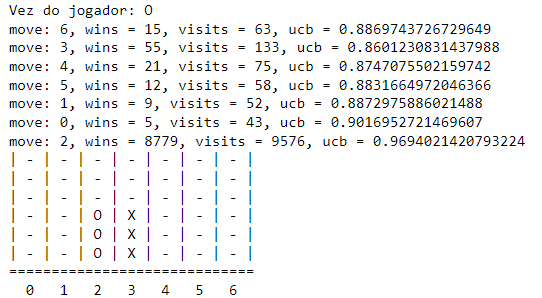

In [7]:
from IPython.display import Image
# Caminho para a imagem
caminho_imagem = 'aumento_c.png'
# Exibir a imagem
Image(filename=caminho_imagem)

**SOLUÇÃO:**

Quando o valor da constante era muito baixo o programa considerava que a melhor solução era aquela com a taxa wins/visits mais alta, no entanto, isto nem sempre é verdade, principalmente em casos como demonstrados na figura a cima. Neste caso, era detetada uma convergência prematura para ações que pareciam ser promissoras, mas que no entanto não o eram. Deste modo, após serem testados diversos valores para a constante o que funcionou melhor foi 4,2 que permite que o algoritmo não tenha tendência a fazer muitas mais visitas num único nó e lhe permite explorar outras opções.

[[voltar a Monte Carlo Tree Search]](#mcts)

##### PROBLEMA 3: 4.2 é de facto o melhor valor para a constante?<a name = "mcts_p3"></a>

Ao escolhermos 4.2 como o valor da constante, o programa de facto começou a explorar melhor as suas opções, contudo na decisão final de qual devia ser a melhor jogada este dava demasiada importância à exploration e não tanto à exploitation, como podemos ver na figura em baixo, levando a casos em que a solução continuava a não ser a melhor.

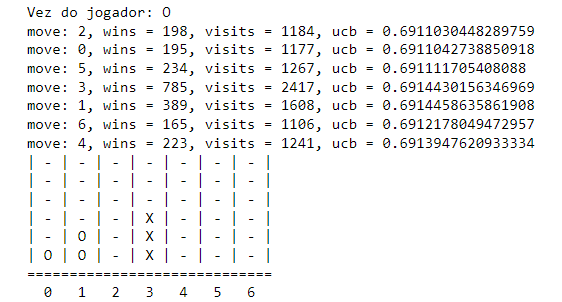

In [8]:
from IPython.display import Image
# Caminho para a imagem
caminho_imagem = 'taxa_vitórias.png'
# Exibir a imagem
Image(filename=caminho_imagem)

**SOLUÇÃO:**

Como não queriamos que o programa voltasse a realizar convergências prematuras, não podiamos baixar o valor da constante, contudo queriamos que de facto na decisão final fosse escolhida a jogada mais promissora. De modo a tornar isto uma realidade foi criada uma outra função chamada choose_answer() que faz um cálculo muito parecido ao realizado pelo UCB, mas apenas considera a parte da exploitation. Assim ao permitir que na decisão final seja escolhida a jogada com maior probabilidade de vencer, wins/visits, o algoritmo demonstrou-se muito mais eficaz.

[[voltar a Monte Carlo Tree Search]](#mcts)

In [9]:
# No select node o código escolhe o melhor nó
# Só permite fazer a expansão de um nó filho de um nó quando todos os nós filhos do nó foram visitados
class Node():
    def __init__(self, game, player, parent, column):
        self.state = game  # guarda o estado atual do jogo
        self.player = player  # guarda o jogador que fez a jogada
        self.parent = parent  # guarda o nó pai
        self.children = []  # guarda uma lista com os nós filhos
        self.visits = 0  # guarda o númeor de vezes que este nó foi visitado
        self.wins = 0  # númeor de vezes que ganhou
        self.column = column
        self.pm = [col for col in range(7) if self.state.pm[col][0] != -1]  # apenas adiciona jogadas possivies que estão por fazer
        self.n_child = 0

class MCTS():
    # Inicia o algoritmo indicando a root
    def __init__(self, game, n_child):
        self.root = Node(game, game.current_player, None, None)  # criamos a root
        self.n_child = n_child
        #print(f"ROOT: {self.root}, player = {self.root.player}, children = {self.root.children}, pm = {self.root.pm}")
    
    # Função que vai escolher a melhor jogada possivel com x iterações   
    def choose_move_iter(self, iteracions = 10000):
        for _ in range(iteracions):
            selected_node = self.select_node(self.root)   # escolhe um nó para expandir
            if self.is_terminal(selected_node):
                result = self.simulate(selected_node)
                self.backpropagate(selected_node, result, self.root.player)
            else:
                expanded_node = self.expand_node(selected_node) # expande o nó escolhido e retorna a expansão
                result = self.simulate(expanded_node)
                self.backpropagate(expanded_node, result, self.root.player)
        #for child in self.root.children:
        #    print(f"move: {child.column}, wins = {child.wins}, visits = {child.visits}, ucb = {self.ucb(child)}")
        best_node = self.choose_answer(self.root)
        return best_node.column


    # Função que vai escolher a melhor jogada possivel em x tempo   
    def choose_move_time(self, end_time = 10):
        start = time.time()
        while time.time() - start < end_time:
            selected_node = self.select_node(self.root)   # escolhe um nó para expandir
            if self.is_terminal(selected_node):
                result = self.simulate(selected_node)
                self.backpropagate(selected_node, result, self.root.player)
            else:
                expanded_node = self.expand_node(selected_node) # expande o nó escolhido e retorna a expansão
                result = self.simulate(expanded_node)
                self.backpropagate(expanded_node, result, self.root.player)
        #for child in self.root.children:
        #    print(f"move: {child.column}, wins = {child.wins}, visits = {child.visits}, ucb = {self.ucb(child)}")
        best_node = self.choose_answer(self.root)
        return best_node.column

    # Função que avalia se um estado é terminal ou não (alguém ganhou ou empatou)
    def is_terminal(self, node):
        game = deepcopy(node.state)
        # Tenho de trocar o current_player porque está a guardar quem vai fazer a jogada
        # Mas neste caso a jogada já foi feita pelo outro jogador
        game.change_player()    
        if game.check_win() or game.moves_left == 0:
            return True
        return False 
    
    # Escolhe o que tem maior taxa de vitórias
    def choose_answer(self, node):
        # calcula o maior valor possivel do ucb entre os filhos do nó
        max_value = max(child.wins/child.visits for child in node.children)
        # cria uma lista que guarda todos os nós == max_value
        best_children = [child for child in node.children if child.wins/child.visits == max_value]
        
        return random.choice(best_children)


    # Seleciona o nó a expandir
    def select_node(self, node):
        # Procura um nó folha caso o nó atual já tenha feito todas as jogadas possiveis
        # Caso contrário pm não está vazio
        while not node.pm: 
            if self.is_terminal(node):
                return node
            node = self.select_best_child(node)
        return node
    

    # De entre os filhos de um determinado nó que já visitou pelo menos uma vez cada filho possivel, escolhe o melhor
    # Caso haja mais que um filho com a mesma pontuação escolhe um qualquer
    def select_best_child(self, node):
        # calcula o maior valor possivel do ucb entre os filhos do nó
        max_value = max(self.ucb(child) for child in node.children)
        # cria uma lista que guarda todos os nós == max_value
        best_children = [child for child in node.children if self.ucb(child) == max_value]
        
        return random.choice(best_children)


    # calcula 'upper confidence bound', ajuda-me a escolher qual nó devo seguir 
    def ucb(self, node, c = 4.2):   # c = constante
        if node.visits == 0:
            return float('inf')

        exploitation = node.wins / node.visits
        exploration = math.sqrt(2 * math.log(node.parent.visits) / node.visits)
        return exploitation + c * exploration

    
    # expande o nó, gerando um nó filho random de entre os possiveis
    def expand_node(self, node):
        # escolhe aleatóriamente uma das jogadas possiveis
        move = random.choice(node.pm)
        # de seguida retira-a da lista para não a repetir
        node.pm.remove(move)

        # Agora vai criar o novo nó
        game = deepcopy(node.state) # guarda o estado de jogo do pai
        player = game.current_player    # guarda quem vai fazer a jogada
        game.make_move(move)    # alteramos a cópia com a atualização do movimento
        game.change_player()    # indicamos vai fazer a proxima jogada
        new_node = Node(game, player, node, move)
        node.children.append(new_node)
        node.n_child += 1
        if node.n_child == self.n_child:
            node.pm = []
        return new_node
    

    # Simula jogadas até alguem ganhar ou o jogo ficar empatado e indica quem ganhou
    def simulate(self, node):
        game = deepcopy(node.state) # guarda o estado em que o jogo chega, para depois aplicar aqui os moves

        # Confirma se chegou ou não um estado terminal
        # Se o estado não for terminal volta a colocar o jogo como chegou
        game.change_player()
        if game.check_win():
            return game.current_player
        game.change_player()

        # Faz jogadas random até alguem ganhar ou empatar
        while True:
            available_moves = [col for col in range(7) if game.pm[col][0] != -1]  # apenas adiciona jogadas possivies

            if not available_moves:
                return '-'    # O jogo acaba em empate (não há mais jogadas possiveis)
            
            # Escolhe um movimento random
            move = random.choice(available_moves)
            # Aplica esse movimento ao jogo
            game.make_move(move)

            # Vê se alguem ganhou o jogo
            if game.check_win():
                # Diz quem ganhou
                return game.current_player
        
            game.change_player()


    # Aumenta o número de visitas em todos os nós
    # Apenas acrescenta vitórias aos nós (independentemente do jogador) se o computador ganhou
    def backpropagate(self, node, result, player):
        # se o computador ganhou
        if result == player:
            while node is not None:
                node.visits += 1
                node.wins += 1
                node = node.parent
        else:
            while node is not None:
                node.visits += 1
                node = node.parent

[[voltar a Monte Carlo Tree Search]](#mcts)

### Minimax<a name = "minimax"></a>
[[voltar ao índice]](#indice)

O objetivo do algoritmo Minimax é encontrar a melhor jogada possível para um jogador, assumindo que o adversário também vai escolher a melhor jogada possível. Ele explora todas as possibilidades de jogadas até um determinado nível de profundidade na árvore do jogo e avalia cada movimento com a função de heurística escolhida.

Ao iniciar, vai verificar se o nó atual representa um estado terminal do jogo, ou seja, se alguém ganhou, perdeu ou houve um empate. Se for um estado terminal, o algoritmo retorna uma pontuação baseada no resultado do jogo. Caso contrário, ele gera todas as jogadas possíveis para o jogador atual e avalia cada uma delas.

O algoritmo é então chamado recursivamente para explorar as possíveis jogadas até a profundidade desejada.

Alternativamente, é possível também usar minimax com alpha-beta pruning. Esta variação no algoritmo permite cortar os ramos que devolvem uma pontuação pior à que o algoritmo já encontrou, evitando assim gastos computacionais desnecessários.

Após avaliar todas as jogadas possíveis, retorna a melhor jogada e a sua pontuação associada. 

Em consequência de testes do funcionamento do algoritmo, foi encontrado um problema:

##### PROBLEMA 1: Vitória Desperdiçada <a name = "minimax_p1"></a>


Por vezes, o algoritmo maximizava a escolha de segmentos de 3 peças seguidas em vez de vencer, mas porquê? Concluímos que isto acontecia porque, dependendo da profundidade (dada por depth), escolhia a primeira posição que fosse capaz de vencer em 'depth' ou menos jogadas, no sentido da esquerda para a direita. Isto porque, naturalmente, é mais vantajoso ao algoritmo fazer combinações de 3 peças e de seguida de 4 peças do que fazer apenas uma de 4 peças (acumula mais pontos).

Por exemplo, para uma profundidade 4, em colunas diferentes:

 - Em 3 jogadas, O faz um segmento de 3 (-50), X faz um segmento de 3 (+50) e O vence (-100000000000000) -> total=-100000000000000
 - Em 1 jogada, O vence (-100000000000000) -> total=-100000000000000

Não bastava substituir a atribuição da coluna escolhida para >= ou <= porque, desse modo, o algoritmo escolheria o último testado e não necessariamente o caminho mais curto, voltando ao mesmo problema.


**Solução encontrada**

 Para além de tornar aleatória a escolha de colunas, implementar um sistema de penalização de profundidade! 

Isto é, ainda que ambas as colunas escolhidas permitam vencer em 'depth' ou menos jogadas, a escolhida será aquela que representa um caminho mais curto (menor custo).

A penalização consiste em remover ou adicionar (para jogador 'X' e 'O', respetivamente) o valor '4-depth' na condição de vitória. 


Após esta correção, o algoritmo funciona da seguinte forma quando encontra os casos anteriormente mencionados:

 - Em 3 jogadas, O faz um segmento de 3 (-50), X faz um segmento de 3 (+50) e O vence (-100000000000000 + (4-2)) -> total=-99999999999998
 - Em 1 jogada, O vence (-100000000000000 + (4-4)) -> total=-100000000000000

Pelo que, independentemente da ordem em que aparecem, aquele que vence antes é o escolhido porque passou a ser mais vantajoso.


Para além disso, o algoritmo tem a capacidade de funcionar com as 3 heurísticas estabelecidas.

[[voltar a Minimax]](#minimax)

In [10]:
class Minimax():
    # baseado no pseudocódigo da Wikipedia
    def __init__(self, game, mode=3): 
        # mode: 1==h1 sem pruning, 2==h2 sem pruning, 3==h1 com pruning, 4==h2 com pruning, 5==h3, 6== h3 com pruning
        self.g = game   # guarda o estado em que o jogo chega
        self.mode = mode

    def terminal_node(self):
        return (self.g.moves_left == 0) or self.g.check_win()

    # As vitórias passam a receber uma penalização de acordo com a necessidade que o 
    # algoritmo teve de aprofundar -> mais profundo == menos pontos

    def choose_best_move(self, depth, alpha=-math.inf, beta=math.inf, y=0, x=0):   
        if self.g.moves_left == 0: return (None,0)    # empate, não calcula mais nada
        
        # inicialização de variáveis como tabuleiro e lista de posições possíveis
        game=self.g
        possible_moves= [game.pm[i] for i in range(7) if game.pm[i][0] != -1] # posições possíveis: ([y,x])
       
        if self.terminal_node():
            if game.current_player=='X': # peça X, pontuação positiva, vence
                return (None, 100000000000000 - (4-depth))  # penalizado se aprofundar mais (escolhe caminho mais curto)

            else: # peça O, pontuação negativa, vence
                return (None, -100000000000000 + (4-depth)) 

        elif depth==0:  # final da propagação retorna apenas a pontuação heurística do movimento
            if self.mode in [1,3]: return (None, evaluate_move(y, x, game.board, game.current_player)) # heurística 1
            elif self.mode in [2,4]: return (None, new_evaluation(game.board, game.current_player)) # heurística 2
            else: return (None, best_evaluation(game.board, game.current_player)) # heurística 3

        if game.current_player=='X': 
            value= -math.inf
            column=random.choice(possible_moves)[1] # escolhe coluna possível aleatória
            while len(possible_moves)!=0:
                move=random.choice(possible_moves)
                possible_moves.remove(move)
                y,x=move[0],move[1]
                new_board=deepcopy(game)
                new_board.make_play(move[1],False)  # escolhe coluna de dentro das possíveis
                
                # decisões diferentes para cada modo (requer atributos diferentes)
                if self.mode==1: new_score=Minimax(new_board, 1).choose_best_move(depth-1, 0, 0, y, x)[1]
                elif self.mode==2: new_score=Minimax(new_board, 2).choose_best_move(depth-1)[1]
                elif self.mode==3: new_score=Minimax(new_board, 3).choose_best_move(depth-1, alpha, beta, y, x)[1]
                elif self.mode==4: new_score=Minimax(new_board, 4).choose_best_move(depth-1, alpha, beta)[1]
                elif self.mode==5: new_score=Minimax(new_board, 5).choose_best_move(depth-1,)[1]
                elif self.mode==6: new_score=Minimax(new_board, 6).choose_best_move(depth-1, alpha, beta)[1]
                
                if new_score > value:
                    value=new_score
                    column=move[1]

                if self.mode in [3,4,6]: # se for um modo com pruning ativo
                    alpha = max(alpha, value)
                    if alpha > beta: break

            return column, value
        
        else:
            value= math.inf
            column=random.choice(possible_moves)[1] # escolhe coluna possível aleatória
            while len(possible_moves)!=0:
                move=random.choice(possible_moves)
                possible_moves.remove(move)
                y,x=move[0],move[1]
                new_board=deepcopy(game)
                new_board.make_play(move[1],False)  # escolhe coluna de dentro das possíveis
                
                
                # decisões diferentes para cada modo (requer atributos diferentes)
                if self.mode==1: new_score=Minimax(new_board, 1).choose_best_move(depth-1, 0, 0, y, x)[1]
                elif self.mode==2: new_score=Minimax(new_board, 2).choose_best_move(depth-1)[1]
                elif self.mode==3: new_score=Minimax(new_board, 3).choose_best_move(depth-1, alpha, beta, y, x)[1]
                elif self.mode==4: new_score=Minimax(new_board, 4).choose_best_move(depth-1, alpha, beta)[1]
                elif self.mode==5: new_score=Minimax(new_board, 5).choose_best_move(depth-1, 0, 0, y, x)[1]
                elif self.mode==6: new_score=Minimax(new_board, 6).choose_best_move(depth-1, alpha, beta, y, x)[1]
                
                if new_score <= value: 
                    value=new_score
                    column=move[1]
                
                if self.mode in [3,4,6]: # se for um modo com pruning ativo    
                    beta = min(beta, value)
                    if alpha > beta: break

            return column, value

[[voltar a Minimax]](#minimax)

## Interface <a name = "interface"></a>
[[voltar ao índice]](#indice)

De modo a ser possivel jogar o Connect Four no terminal, foram desenvolvidas diversas funções que tem como objetivo melhorar a experiência do jogador.

Para que seja mais fácil perceber o que cada porção de código faz subdividimos o jogo no terminal em duas grandes partes.

#### Menu <a name = "menu_terminal"></a>
[[voltar à Interface]](#interface)

Este conjunto de funções dedica-se a gerir todas as funcionalidades a que o jogador pode usufruir, desde escolher se quer jogar contra o computador ou não, a escolher qual o algoritmo utilizado pelo computador ou se prefere ser o jogador número 1 ou 2. Existem muitas mais funcionalidades que encorajamos a testar.

In [11]:
# Gere o menu
def menu_terminal():
    print()
    print("---------- MENU ----------")
    print("   - Jogador_1 VS Jogador_2 (1)")
    print("   - Jogador VS PC (2)")
    print("   - PC VS PC (3)")
    choice = input("Escolhe a opção 1, 2 ou 3: ")
    while choice not in ['1', '2', '3', 'quit']:
        print("Input incorreto, por favor tente novamente.")
        choice = input("Escolha a opção 1, 2 ou 3: ")
    
    if choice == '1':
        outcome = play_in_terminal_1()
        if outcome == 'menu':
            menu_terminal()
        elif outcome == 'quit':
            return
        else:
            outcome = game_ended()
            while outcome == 'end':
                outcome = play_in_terminal_1()
                if outcome == 'menu':
                    menu_terminal()
                elif outcome == 'quit':
                    return
                outcome = game_ended()
            if outcome == 'quit':
                    return
                
    elif choice == '2':
        player = player1_or_player2()
        if player == 'quit':
            return
        algorithm = choose_algorithm()
        if algorithm == 'quit':
            return
        if algorithm == 'A*':
            outcome = play_in_terminal_2(algorithm, player)
            if outcome == 'menu':
                menu_terminal()
            elif outcome == 'quit':
                return
            else:
                outcome = game_ended()
                while outcome == 'end':
                    outcome = play_in_terminal_2(algorithm, player)
                    if outcome == 'menu':
                        menu_terminal()
                    elif outcome == 'quit':
                        return
                    outcome = game_ended()
                if outcome == 'quit':
                    return
                
        elif algorithm == 'MCTS':
            mcts_mode, mcts_time, mcts_iter, mcts_childs = options_mcts()
            if mcts_mode == 'quit' or mcts_time == 'quit' or mcts_iter == 'quit' or mcts_childs == 'quit':
                return
            outcome = play_in_terminal_2(algorithm, player, mcts_mode = mcts_mode, mcts_time = mcts_time, mcts_iter = mcts_iter, mcts_childs = mcts_childs)
            if outcome == 'menu':
                menu_terminal()
            elif outcome == 'quit':
                return
            else:
                outcome = game_ended()
                while outcome == 'end':
                    outcome = play_in_terminal_2(algorithm, player, mcts_mode = mcts_mode, mcts_time = mcts_time, mcts_iter = mcts_iter, mcts_childs = mcts_childs)
                    if outcome == 'menu':
                        menu_terminal()
                    elif outcome == 'quit':
                        return
                    outcome = game_ended()
                if outcome == 'quit':
                    return        
        
        elif algorithm == 'Minimax':
            minimax_mode, minimax_depth = choose_heuristic()
            if minimax_mode == 'quit':
                return
            outcome = play_in_terminal_2(algorithm, player, minimax_mode = minimax_mode, minimax_depth = minimax_depth)
            if outcome == 'menu':
                menu_terminal()
            elif outcome == 'quit':
                return
            else:
                outcome = game_ended()
                while outcome == 'end':
                    outcome = play_in_terminal_2(algorithm, player, minimax_mode = minimax_mode, minimax_depth = minimax_depth)
                    if outcome == 'menu':
                        menu_terminal()
                    elif outcome == 'quit':
                        return
                    outcome = game_ended()
                if outcome == 'quit':
                    return     
    
    elif choice == '3':
        player1, player2, x1, x2, x3, x4, y1, y2, y3, y4 = choose_algorithms_PC()
        if player1 == 'quit':
            return
        outcome = play_in_terminal_3(player1, player2, x1, x2, x3, x4, y1, y2, y3, y4)
        if outcome == 'menu':
            menu_terminal()
        elif outcome == 'quit':
            return
        else:
            outcome = game_ended()
            while outcome == 'end':
                outcome = play_in_terminal_3(player1, player2, x1, x2, x3, x4, y1, y2, y3, y4)
                if outcome == 'menu':
                    menu_terminal()
                elif outcome == 'quit':
                    return
                outcome = game_ended()
            if outcome == 'quit':
                return                   
                
    else:
        return

# Escolhe os algoritmos a serem usados em PC VS PC
def choose_algorithms_PC():
    print()
    print("Qual queres que seja o primeiro algoritmo a jogar?")
    print("   - A* (1)")
    print("   - Minimax (2)")
    print("   - MCTS (3)")
    player1 = input("Escolhe a opção 1, 2 ou 3: ")
    while player1 not in ['1', '2', '3', 'quit', 'menu']:
        print("Input incorreto, por favor tente novamente.")
        player1 = input("Escolha a opção 1, 2 ou 3: ")
    
    if player1 == '1':
        player1 = 'A*'
        x1 = None
        x2 = None
        x3 = None
        x4 = None
    elif player1 == '2':
        player1 = 'Minimax'
        x1, x2 = choose_heuristic()
        if x1 == 'quit':
            return 'quit', None, None, None, None, None, None, None, None, None
        x3 = None
        x4 = None
    elif player1 == '3':
        player1 = 'MCTS'
        x1, x2, x3, x4 = options_mcts()
        if x1 == 'quit' or x2 == 'quit' or x3 == 'quit' or x4 == 'quit':
            return 'quit', None, None, None, None, None, None, None, None, None
    else:
        return 'quit', None, None, None, None, None, None, None, None, None

    print()
    print("E o segundo?")
    print("   - A* (1)")
    print("   - Minimax (2)")
    print("   - MCTS (3)")
    player2 = input("Escolhe a opção 1, 2 ou 3: ")
    while player2 not in ['1', '2', '3', 'quit', 'menu']:
        print("Input incorreto, por favor tente novamente.")
        player2 = input("Escolha a opção 1, 2 ou 3: ")
    
    if player2 == '1':
        player2 = 'A*'
        y1 = None
        y2 = None
        y3 = None
        y4 = None
    elif player2 == '2':
        player2 =  'Minimax'
        y1, y2 = choose_heuristic()
        if y1 == 'quit':
            return 'quit', None, None, None, None, None, None, None, None, None
        y3 = None
        y4 = None
    elif player2 == '3':
        player2 =  'MCTS'
        y1, y2, y3, y4 = options_mcts()
        if y1 == 'quit' or y2 == 'quit' or y3 == 'quit' or y4 == 'quit':
            return 'quit', None, None, None, None, None, None, None, None, None
    else:
        return 'quit', None, None, None, None, None, None, None, None, None

    return player1, player2, x1, x2, x3, x4, y1, y2, y3, y4

    
# Ser o jogador 1 ou o jogador 2
def player1_or_player2():
    print()
    print("Queres ser:")
    print("   - jogador_1 (1)")
    print("   - jogador_2 (2)")
    choice = input("Escolhe a opção 1 ou 2: ")
    while choice not in ['1', '2', 'quit', 'menu']:
        print("Input incorreto, por favor tente novamente.")
        choice = input("Escolha a opção 1 ou 2: ")
    
    if choice == '1':
        return '1'
    elif choice == '2':
        return '2'
    elif choice == 'menu':
        menu_terminal()
    else:
        return 'quit'

# Escolhe o algoritmo contra quem joga
def choose_algorithm():
    print()
    print("Queres jogar contra:")
    print("   - A* (1)")
    print("   - Minimax (2)")
    print("   - MCTS (3)")
    choice = input("Escolhe a opção 1, 2 ou 3: ")
    while choice not in ['1', '2', '3', 'quit', 'menu']:
        print("Input incorreto, por favor tente novamente.")
        choice = input("Escolha a opção 1, 2 ou 3: ")

    if choice == '1':
        return 'A*'
    elif choice == '2':
        return 'Minimax'
    elif choice == '3':
        return 'MCTS'
    elif choice == 'menu':
        menu_terminal()
    else:
        return 'quit'

# Escolher a heuristica para o Minimax
def choose_heuristic():
    print()
    print("Queres que o Minimax use qual das opções:")
    print("   - Heurística 1 sem pruning (1)")
    print("   - Heurística 2 sem pruning (2)")
    print("   - Heurística 1 com pruning (3)")
    print("   - Heurística 2 com pruning (4)")
    choice = input("Escolhe a opção 1, 2, 3 ou 4: ")
    while choice not in ['1', '2', '3', '4', 'menu', 'quit']:
        print("Input incorreto, por favor tente novamente.")
        choice = input("Escolha a opção 1, 2, 3 ou 4: ")
    
    if choice != 'quit':
        depth = input("Qual a profundiade que queres que o Minimax tenha? (recomendado = 4) ")

    if choice == '1':
        return 1, int(depth)
    elif choice == '2':
        return 2, int(depth)
    elif choice == '3':
        return 3, int(depth)
    elif choice == '4':
        return 4, int(depth)
    elif choice == 'menu':
        menu_terminal()
    else:
        return 'quit', None



# Escolhe o modo como o MCTS atua, tempo ou iterações
def options_mcts():
    print()
    print("Queres que o MCTS jogo a partir de qual destas opções:")
    print("   - Tempo (1)")
    print("   - Iterações (2)")
    choice = input("Escolhe a opção 1, ou 2: ")
    while choice not in ['1', '2', 'menu', 'quit']:
        print("Input incorreto, por favor tente novamente.")
        choice = input("Escolha a opção 1, ou 2: ")
    
    if choice == '1':
        mcts_mode = 'tempo'
        mcts_time = get_mcts_time(mcts_mode)
        mcts_childs = get_mcts_childs()
        return mcts_mode, mcts_time, None, mcts_childs
    elif choice == '2':
        mcts_mode = 'iterações'
        mcts_iter = get_mcts_iter(mcts_mode)
        mcts_childs = get_mcts_childs()
        return mcts_mode, None, mcts_iter, mcts_childs
    elif choice == 'menu':
        menu_terminal()
    else:
        return 'quit', None, None, None

# Define o número o tempo que o MCTS tem
def get_mcts_time(mcts_mode):
    print()
    print(f"Escolheste usar o MCTS à base de {mcts_mode}.")
    choice = input("Quanto tempo queres que ele tenha? (em segundos) ")
    
    if choice == 'menu':
        menu_terminal()
    elif choice == 'quit':
        return 'quit'
    else:
        return int(choice)

# Define o número de iterações que o MCTS faz
def get_mcts_iter(mcts_mode):
    print()
    print(f"Escolheste usar o MCTS à base de {mcts_mode}.")
    choice = input("Quantas iterações queres que ele faça? ")
    
    if choice == 'menu':
        menu_terminal()
    elif choice == 'quit':
        return 'quit'
    else:
        return int(choice)
    
# Define o número de filhos que o MCTS usa
def get_mcts_childs():
    print()
    choice = input("Quantos filhos queres que sejam gerados por iteração? ")
    
    if choice == 'menu':
        menu_terminal()
    elif choice == 'quit':
        return 'quit'
    else:
        return int(choice)

# Quando o jogo termina porque alguem ganhou ou empatou, dá hipoteses do que fazer a seguir
def game_ended():
    print("   - Jogar outra vez (1)")
    print("   - Menu (2)")
    print("   - Sair (3)")
    choice = input("Escolhe a opção 1, 2 ou 3: ")
    while choice not in ['1', '2', '3', 'menu', 'quit']:
        print("Input incorreto, por favor tente novamente.")
        choice = input("Escolha a opção 1, 2 ou 3: ")
    
    if choice == '1':
        return 'end'
    elif choice in ['2', 'menu']:
        menu_terminal()
    elif choice in ['3', 'quit']:
        return 'quit'

#### Modos de Jogo <a name = "modos_terminal"></a>
[[voltar à Interface]](#interface)

Nesta porção de código encontram-se três funções, sendo cada uma destinada à execução de um modo de jogo diferente: 'Jogador1 VS Jogador2', 'Jogador VS Computador' e 'Computador VS Computador'.

In [12]:
# JOGADOR VS JOGADOR
def play_in_terminal_1():
    print()
    print("--- JOGADOR VS JOGADOR ---")
    print()
    game = ConnectFour()
    game.print_board()  # dá print ao tabuleiro no inicio do jogo (que se encontra vazio)
    while not game.e:
        print(f"Vez do jogador: {game.current_player}")
        column = input("Escolha uma coluna (0-6):")
        while column not in ['0', '1', '2', '3', '4', '5', '6', 'quit', 'menu']:
            print("Input incorreto, por favor tente novamente.")
            column = input("Escolha uma coluna (0-6):")

        if column == 'quit':
            return 'quit'
        elif column == 'menu':
            return 'menu'
        else:
            game.make_play(int(column))
    return 'end'
    
# JOGADOR VS PC
def play_in_terminal_2(game_mode, player, mcts_mode = None, mcts_time = None, mcts_iter = None, mcts_childs = None, minimax_mode = None, minimax_depth = None):
    print()
    print("--- JOGADOR VS PC ---")
    print()
    if player == '1':   
        choice = 1  # choice = 1 começa o jogador
    else:
        choice = -1 # choice = -1 começa o PC
    game = ConnectFour()
    game.print_board()  # dá print ao tabuleiro no inicio do jogo (que se encontra vazio)
    while not game.e:
        print(f"Vez do jogador: {game.current_player}")
        if (choice == 1):
            column = input("Escolha uma coluna (0-6):")
            while column not in ['0', '1', '2', '3', '4', '5', '6', 'quit', 'menu']:
                print("Input incorreto, por favor tente novamente.")
                column = input("Escolha uma coluna (0-6):")

            if column == 'quit':
                return 'quit'
            elif column == 'menu':
                return 'menu'
            else:
                game.make_play(int(column))
        else:
            if game_mode == 'A*':
                a_star = Astar(game)
                column = a_star.choose_move()
            elif game_mode == 'Minimax':
                minimax = Minimax(game, minimax_mode)
                column, _ = minimax.choose_best_move(minimax_depth)
            elif game_mode == 'MCTS':
                mcst = MCTS(game, mcts_childs)
                if mcts_mode == 'tempo':
                    column = mcst.choose_move_time(mcts_time)
                else:
                    column = mcst.choose_move_iter(mcts_iter)
            game.make_play(column)

        choice *= -1
    return 'end'


# PC VS PC
# JOGADOR VS PC
def play_in_terminal_3(player1, player2, x1 = None, x2 = None, x3 = None, x4 = None, y1 = None, y2 = None, y3 = None, y4 = None):
    print()
    print("--- PC VS PC ---")
    print()
    game = ConnectFour()
    game.print_board()  # dá print ao tabuleiro no inicio do jogo (que se encontra vazio)
    control = 1 # Quando for 1 joga o player 1, quando for -1 joga o player 2
    while not game.e:
        if control == 1:
            player = player1
            print(f"Vez do jogador: {game.current_player} - Algoritmo {player}")
            if player == 'A*':
                a_star = Astar(game)
                column = a_star.choose_move()
            elif player == 'Minimax':
                minimax = Minimax(game, x1)
                column, _ = minimax.choose_best_move(x2)
            elif player == 'MCTS':
                mcst = MCTS(game, x4)
                if x1 == 'tempo':
                    column = mcst.choose_move_time(x2)
                else:
                    column = mcst.choose_move_iter(x3)
        else:
            player = player2
            print(f"Vez do jogador: {game.current_player} - Algoritmo {player}")
            if player == 'A*':
                a_star = Astar(game)
                column = a_star.choose_move()
            elif player == 'Minimax':
                minimax = Minimax(game, y1)
                column, _ = minimax.choose_best_move(y2)
            elif player == 'MCTS':
                mcst = MCTS(game, y4)
                if y1 == 'tempo':
                    column = mcst.choose_move_time(y2)
                else:
                    column = mcst.choose_move_iter(y3)
        
        game.make_play(column)
        control *= -1
    return 'end'

Apesar de na função play_in_terminal_2() ser bastante explícito quais os parâmetros que podem ser fornecidos na entrada padrão, a função play_in_terminal_3() não apresenta tanta clareza. Tal deve-se ao facto de não se saber quais os parâmetros que esta deve receber. Sendo play_in_terminal_3() utilizada para fazer jogos entre 2 algoritmos, distintos ou não, apenas sabemos que valores dar às funções quando se sabe quais foram os algoritmos designados a serem utilizados. De modo a combater este problema, a função recebe um player1 e um player2 que correspondem a 'A*', 'Minimax' e 'MCTS' e um conjunto de quatro variaveis para cada um, que tem como objetivo receber as caracteristicas que devem ser utilizadas em cada algoritmo. Assim sendo, x1, x2, x3 e x4 dizem respeito às características do algoritmo selecionado em player1 e y1, y2, y3 e y4 ao player2. De modo a perceber o que fazem exatamente cada um destes parâmetros em cada algoritmo tenha atenção à seguinte explicação:

**A Star:**
- x1 / y1 = None
- x2 / y2 = None
- x3 / y3 = None
- x4 / y4 = None

Uma vez que este algoritmo funciona apenas usando a Heurística 1 sem pruning, não houve a necessidade de utlizar os parâmetros.

**Minimax**
- x1 / y1 = minimax_mode
- x2 / y2 = minimax_depth
- x3 / y3 = None
- x4 / y4 = None

Neste caso já é possivel variar qual a heuristica a ser utilizada e se tem ou não prunning e qual a profundidade da pesquisa.

**MCTS**
- x1 / y1 = mcts_mode
- x2 / y2 = mcts_time
- x3 / y3 = mcts_iter
- x4 / y4 = n_childs

Este é o algoritmo que tem mais nuances, sendo possivel escolher se este vai funcionar à base de iterações ou de tempo e indicando qual o número de iterações ou o tempo dispensado para a pesquisa. Também é possivel determinar qual o número de nós filhos que são possiveis selecionar, ou seja, cada nó apenas tem o número de nós filhos que lhe for permitido. 

#### Iniciar Jogo no Terminal <a name = "start_terminal"></a>
[[voltar à Interface]](#interface)

Aqui encontra-se a função que permite iniciar o jogo 'Connect Four' no terminal.

In [13]:
# Inicia tudo o que diz respeito ao terminal
def start_terminal():
    print()
    print("Bem vindo à versão do jogo 'Connect Four' em terminal.")
    print("Se em qualquer momento quiseres terminar o jogo basta escrever 'quit'.")
    print("Se quiseres ir ao menu e fazer alterações escreve 'menu'.")
    menu_terminal()

Se quiseres testar este formato de jogo basta retirares o código de comment line.

In [14]:
#start_terminal()

 -----------------------------------------------------------------------------------------------------------------------

## Testes <a name = "testes"></a>
[[voltar ao índice]](#indice)

**Para a resolução dos três primeiros testes foi utilizado o seguinte código:**

De modo a obter resultados mais fidedignos e realistas mas obtidos rapidamente, foi utilizada uma profundidade de 3 e foram realizadas 10 iterações para cada teste.

Caso assim deseje, é também possível ver todas as jogadas para cada algoritmo (show_every=True) ou apenas os tabuleiros de 'end game' (show_final=True).


In [15]:
def test_performance(mode1,mode2,iter=3,show_final=False,show_every=False):
    # se show_every==True, mostra todas as jogadas feitas por cada algoritmo
    # modes: 1==h1 , 2==h2 , 3==h1 pruning, 4==h2 pruning, 5==h3, 6==h3 pruning
    times1=[]
    times2=[]
    avg1=[]
    avg2=[]
    win1=0
    win2=0
    
    for i in tqdm(range(iter), desc='A testar... '):
        game = ConnectFour()
        choice=1
        
        while not game.e:
            if (choice == 1):
                minimax = Minimax(game, mode1) 
                t1=perf_counter()
                column, _ = minimax.choose_best_move(3)  
                game.make_play(int(column),show_every)                
                t2=perf_counter()
                times1.append(t2-t1)
            else:
                minimax = Minimax(game, mode2) 
                t1=perf_counter()
                column, _ = minimax.choose_best_move(3)  
                game.make_play(int(column),show_every)
                t2=perf_counter()
                times2.append(t2-t1)
            choice *= -1    
        
        if show_final:game.print_board()  # mostra os tabuleiros quando o jogo termina
        # incrementa contagem dos vencedores cada vez que um jogo acaba e nao é empate
        if game.check_win():
            if game.current_player == 'X':
                win1 += 1
            else:
                win2 += 1

        avg1.append(np.mean(times1))    
        avg2.append(np.mean(times2))
        times1=[]
        times2=[]
    return avg1, avg2, win1, win2  # devolve as duas listas de tempos e contadores de vitórias

### Pruning VS sem pruning <a name = "pruning_vs"></a>
[[voltar a Testes]](#testes)

Primeiro, vamos testar se o algoritmo com pruning (poda alpha-beta) é mais eficaz do que o algoritmo que não usa essa otimização.

A testar... : 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.29s/it]


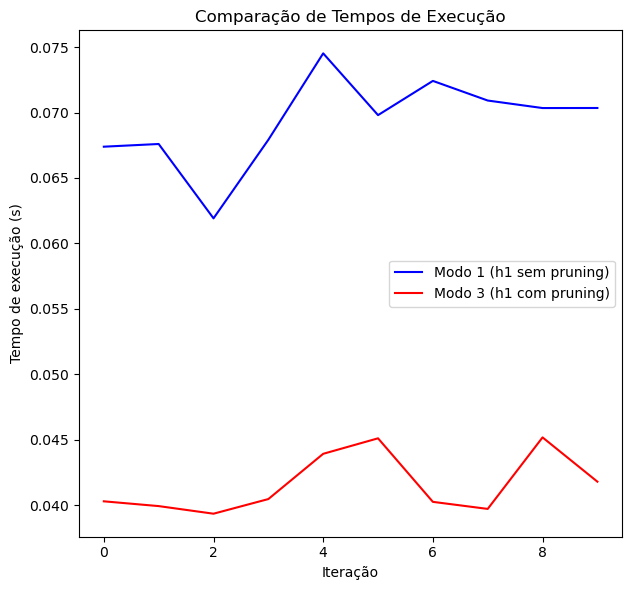

In [16]:
times1,times2,win1,win2=test_performance(1,3,10)

plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times1, label='Modo 1 (h1 sem pruning)', color='blue')
plt.plot(times2, label='Modo 3 (h1 com pruning)', color='red')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

plt.tight_layout()
plt.show()

Apenas verificamos a diferença de tempo pois qualquer conclusão tirada através do número de vitórias sem variar a heurística seria puramente aleatória, já que a profundidade e o modo de avaliação são mantidos e a poda alpha-beta afeta apenas tempos de execução.

Como podemos observar, o algoritmo otimizado com poda alpha-beta é (como esperado) consistentemente mais rápido do que aquele que não a usa, pelo que podemos concluir que é preferível usar a primeira versão para futuros testes ou jogos.

Isto ocorre porque a otimização de pruning elimina a necessidade de explorar caminhos menos promissores na árvore de decisão, ao 'podar' caminhos se já foram encontrados outros com uma melhor pontuação, evitando assim a análise de outros caminhos que não vão afetar o resultado final.

Concluímos, portanto, que usar a poda alpha-beta é computacionalmente mais vantajoso e consistentemente mais rápido. Posto isto, vamos usar a versão com otimização para os testes seguintes, onde vamos comparar o desempenho das heurísticas, bem como os seus tempos de execução.

[[voltar a Pruning VS sem pruning]](#pruning_vs)

### Heurística 1 VS Heurística 2 <a name = "heuristicas_vs"></a>
[[voltar a Testes]](#testes)

Tendo em conta que a [Heurística 2](#heuristica_2) foi concebida com o objetivo de melhorar o funcionamento do [Minimax](#minimax), iremos utilizar este algoritmo para fazer um jogo adversarial entre o Minimax que usa a Heurística 1 e o que usa a Heurística 2.

Para este efeito, foi criada uma função que avalia e compara os desempenhos do algoritmo relativamente aos tempos de execução e número de vitórias quando se altera a heurística ou o uso de pruning.

A testar... : 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


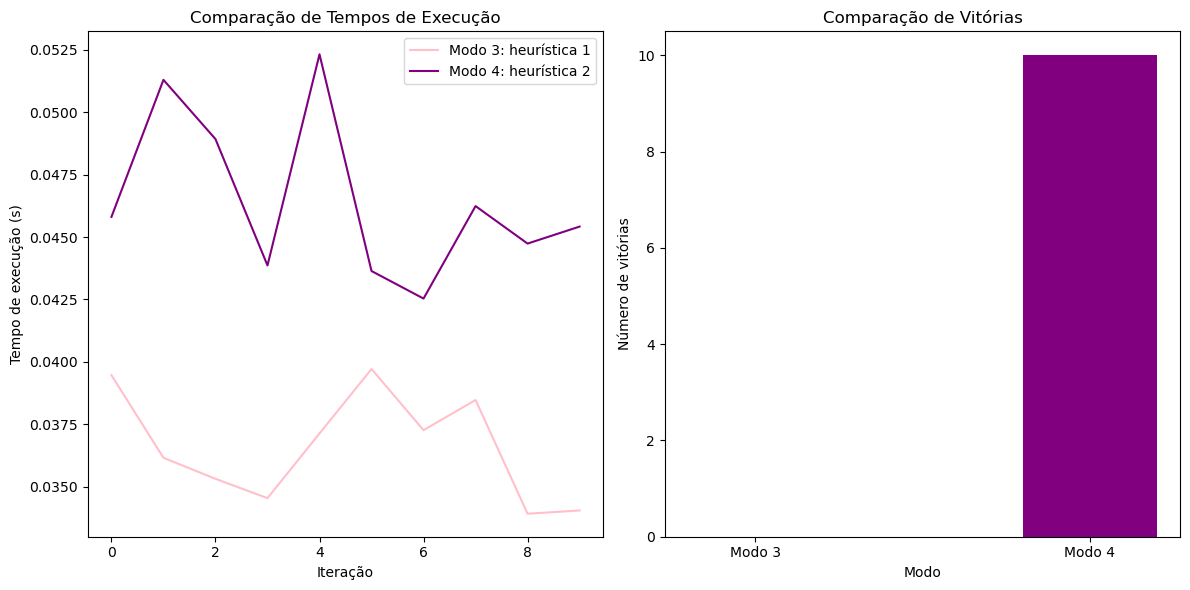

A testar... : 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.19it/s]


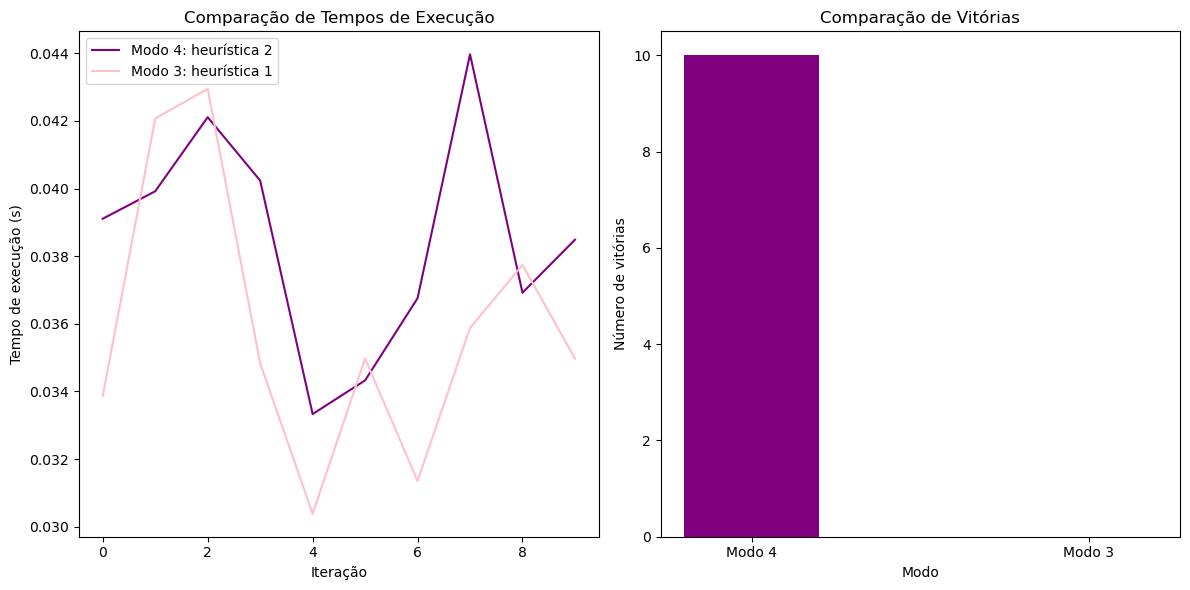

In [17]:
times1,times2,win1,win2=test_performance(3,4,10)

plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times1, label='Modo 3: heurística 1', color='pink')
plt.plot(times2, label='Modo 4: heurística 2', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['Modo 3', 'Modo 4'], [int(win1), int(win2)], color=['pink', 'purple'], width=0.4)
plt.xlabel('Modo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

times1,times2,win1,win2=test_performance(4,3,10)

plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times1, label='Modo 4: heurística 2', color='purple')
plt.plot(times2, label='Modo 3: heurística 1', color='pink')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['Modo 4', 'Modo 3'], [int(win1), int(win2)], color=['purple', 'pink'], width=0.4)
plt.xlabel('Modo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

Como era de esperar, a heurística 1 foi muito mais rápida. É fácil de perceber que tal sucede porque a heurística 1 só verifica a última posição colocada, ao passo
que a heurística 2 verifica sempre o tabuleiro inteiro em todas as direções possíveis.

Surpreendentemente, a heurística 2 venceu a heurística 1 na avassaladora maioria das vezes (em certos casos, variando iterações, até na totalidade), quer seja jogador1 ou jogador2, pelo que podemos concluir que é vantajoso analisar o tabueiro inteiro ao invés de analisar apenas as peças que rodeiam a última colocada, visto que dar à peça que gera uma vitória uma pontuação muito mais elevada que todas as outras (de 512 passou para 100000000000000) é irrelevante, já que essa pontuação está definida dentro do próprio algoritmo..


[[voltar a Heurística 1 VS Heurística 2]](#heuristicas_vs)

### Heurística 3 VS Heurística 1 <a name = "heuristicas_vs2"></a>
[[voltar a Testes]](#testes)

Posto isto, decidimos criar uma nova heurística 3 que é formada pela combinação da análise do tabuleiro da segunda heurística e o sistema de pontuação da primeira, com a finalidade de perceber o que causou o aumento de vitórias.

Abaixo representamos as comparações de heurística 1 vs heurística 3, usando pruning.

A testar... : 100%|████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.11s/it]


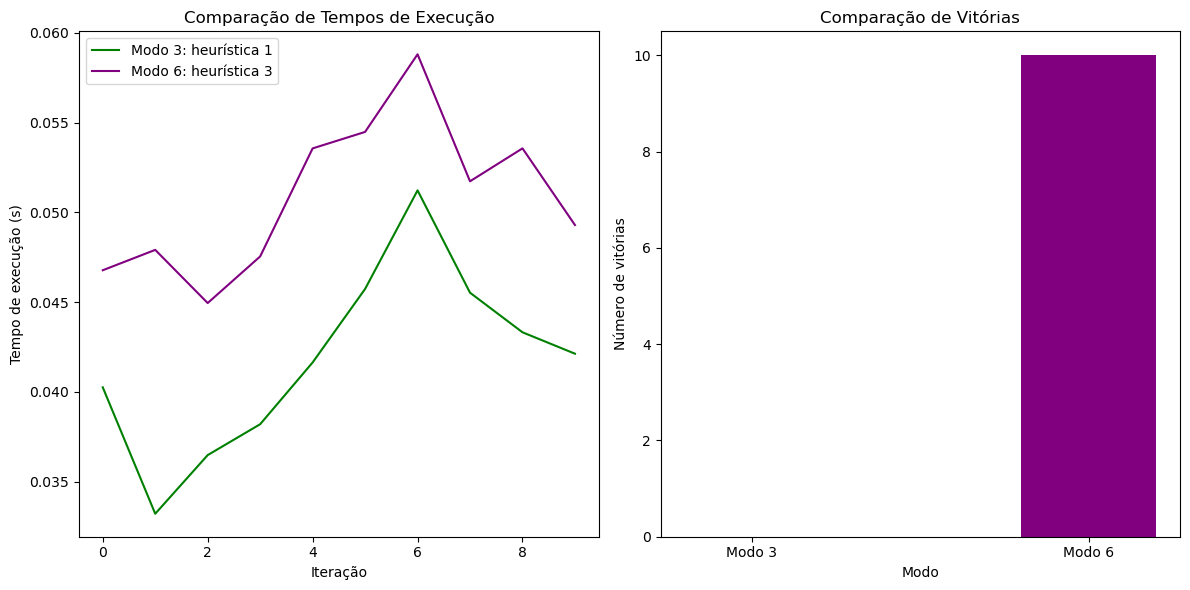

In [18]:
# h1 vs h3
times1_a,times2_a,win1_a,win2_a=test_performance(3,6,10)

plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times1_a, label='Modo 3: heurística 1', color='green')
plt.plot(times2_a, label='Modo 6: heurística 3', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['Modo 3', 'Modo 6'], [int(win1_a), int(win2_a)], color=['green', 'purple'], width=0.4)
plt.xlabel('Modo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

Como a variável que mantivemos constante foi a avaliação criada para a heurística 2 e o algoritmo foi sempre derrotado, podemos concluir que o que causou um aumento significativo de vitórias foi o facto de o algoritmo verificar o tabuleiro inteiro ao invés dos segmentos que rodeiam a peça.

[[voltar a Heurística 3 VS Heurística 1]](#heuristicas_vs2)

**Para os restantes testes foi utilizada uma variação da função play_in_terminal_3()**

Contrariamente à função play_in_terminal_3(), esta permite imprimir ou não os diversos estados do tabuleiro e decidir se queremos ou não ver apenas o estado final do tabuleiro, ou seja, aquele no qual houve uma vitória ou um empate.

In [19]:
def tests(player1, player2, n_games = 10, show_final = False, show_every = False, x1 = None, x2 = None, x3 = None, x4 = None, y1 = None, y2 = None, y3 = None, y4 = None):
    times_1 = []
    times_2 = []
    avg_1 = []
    avg_2 = []
    win_1 = 0
    win_2 = 0
    
    for i in tqdm(range(n_games), desc = 'A testar... '):
        game = ConnectFour()
        if show_every:
            game.print_board()  # dá print ao tabuleiro no inicio do jogo (que se encontra vazio)
        control = 1 # Quando for 1 joga o player 1, quando for -1 joga o player 2
        while not game.e:
            if control == 1:
                player = player1
                if show_every:
                    print(f"Vez do jogador: {game.current_player} - Algoritmo {player}")
                if player == 'A*':
                    a_star = Astar(game)
                    t1 = perf_counter()
                    column = a_star.choose_move()
                    game.make_play(column, show_every)
                    t2 = perf_counter()
                    times_1.append(t2-t1)
                elif player == 'Minimax':
                    minimax = Minimax(game, x1)
                    t1 = perf_counter()
                    column, _ = minimax.choose_best_move(x2)
                    game.make_play(column, show_every)
                    t2 = perf_counter()
                    times_1.append(t2-t1)
                elif player == 'MCTS':
                    mcst = MCTS(game, x4)
                    if x1 == 'tempo':
                        t1 = perf_counter()
                        column = mcst.choose_move_time(x2)
                        game.make_play(column, show_every)
                        t2 = perf_counter()
                        times_1.append(t2-t1)
                    else:
                        t1 = perf_counter()
                        column = mcst.choose_move_iter(x3)
                        game.make_play(column, show_every)
                        t2 = perf_counter()
                        times_1.append(t2-t1)
            else:
                player = player2
                if show_every:
                    print(f"Vez do jogador: {game.current_player} - Algoritmo {player}")
                if player == 'A*':
                    a_star = Astar(game)
                    t1 = perf_counter()
                    column = a_star.choose_move()
                    game.make_play(column, show_every)
                    t2 = perf_counter()
                    times_2.append(t2-t1)
                elif player == 'Minimax':
                    minimax = Minimax(game, y1)
                    t1 = perf_counter()
                    column, _ = minimax.choose_best_move(y2)
                    game.make_play(column, show_every)
                    t2 = perf_counter()
                    times_2.append(t2-t1)
                elif player == 'MCTS':
                    mcst = MCTS(game, y4)
                    if y1 == 'tempo':
                        t1 = perf_counter()
                        column = mcst.choose_move_time(y2)
                        game.make_play(column, show_every)
                        t2 = perf_counter()
                        times_2.append(t2-t1)
                    else:
                        t1 = perf_counter()
                        column = mcst.choose_move_iter(y3)
                        game.make_play(column, show_every)
                        t2 = perf_counter()
                        times_2.append(t2-t1)
            control *= -1
        
        if show_final: game.print_board()
        # Incrementa a contagem dos vencedores cada vez que o jogo acaba e não é empate
        if game.check_win():
            if game.current_player == 'X':
                win_1 += 1
            else:
                win_2 += 1
                
        
        avg_1.append(np.mean(times_1))    
        avg_2.append(np.mean(times_2))
        times_1=[]
        times_2=[]
    return avg_1, avg_2, win_1, win_2 

### Monte Carlo Tree Search Variação de Nós<a name = "mcts_nos"></a>
[[voltar a Testes]](#testes)

Será que limitar o número de nós filhos a que cada nó tem acesso faz diferença?

A testar... : 100%|███████████████████████████████████████████████████████████████████| 10/10 [35:40<00:00, 214.06s/it]


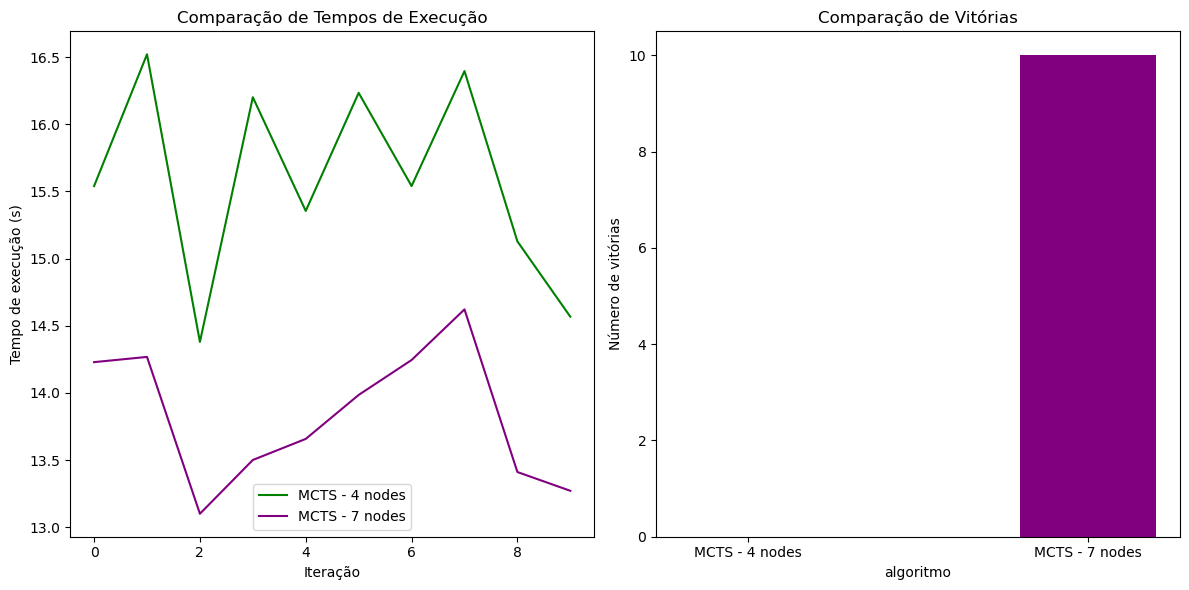

In [20]:
# MCTS 4 E 7 Nodes
times_1,times_2,win_1,win_2 = tests('MCTS', 'MCTS', 10, x1 = 'iterações', x3 = 10000, x4 = 4, y1 = 'iterações', y3 = 10000, y4 = 7)


plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times_1, label='MCTS - 4 nodes', color='green')
plt.plot(times_2, label='MCTS - 7 nodes', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['MCTS - 4 nodes', 'MCTS - 7 nodes'], [int(win_1), int(win_2)], color=['green', 'purple'], width=0.4)
plt.xlabel('algoritmo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

Como podemos observar a partir dos gráficos, utilizar apenas 4 nós é prejudicial, uma vez que restringe a capacidade do algoritmo de explorar linhas de jogadas mais profundas e estratégias de bloqueio, tornando assim, para este jogo o uso do maior número de nós possiveis vantajoso.

Isso ocorre porque o algoritmo com acesso a todos os nós será capaz de explorar muito mais profundamente as possibilidades do jogo. Ele pode identificar as melhores jogadas com muita mais precisão, uma vez que pode avaliar uma gama mais ampla de movimentos possíveis.

Por outro lado, o algoritmo com acesso apenas a 4 nós estará limitado relativamente à capacidade de explorar o espaço de busca do jogo. Ele pode não ser capaz de considerar movimentos que são essenciais para garantir a vitória ou evitar a derrota.

[[voltar a Monte Carlo Tree Search Variação de Nós]](#mcts_nos)

### Monte Carlo Tree Search VS A Star <a name = "mcts_vs_astar"></a>
[[voltar a Testes]](#testes)

Contrariamente ao MCTS, o A* não é um algoritmo adversarial, logo seria de esperar que para este jogo o MCTS obtivesse um número considerável de vitórias contra o A*. No entanto caso a heurística do A* fosse praticamente invencível este poderia ter hipoteses de ganhar.

De modo a tentar obter os melhores resultados possiveis, para este teste será utilizada a Heurística 1 para o A*, que revelou ser computacionalmente mais rápida, e para o MCTS serão realizadas 10 000 iterações estando sempre disponiveis os 7 nós filhos.

**MCTS VS A Star**

A testar... : 100%|████████████████████████████████████████████████████████████████████| 10/10 [08:35<00:00, 51.59s/it]


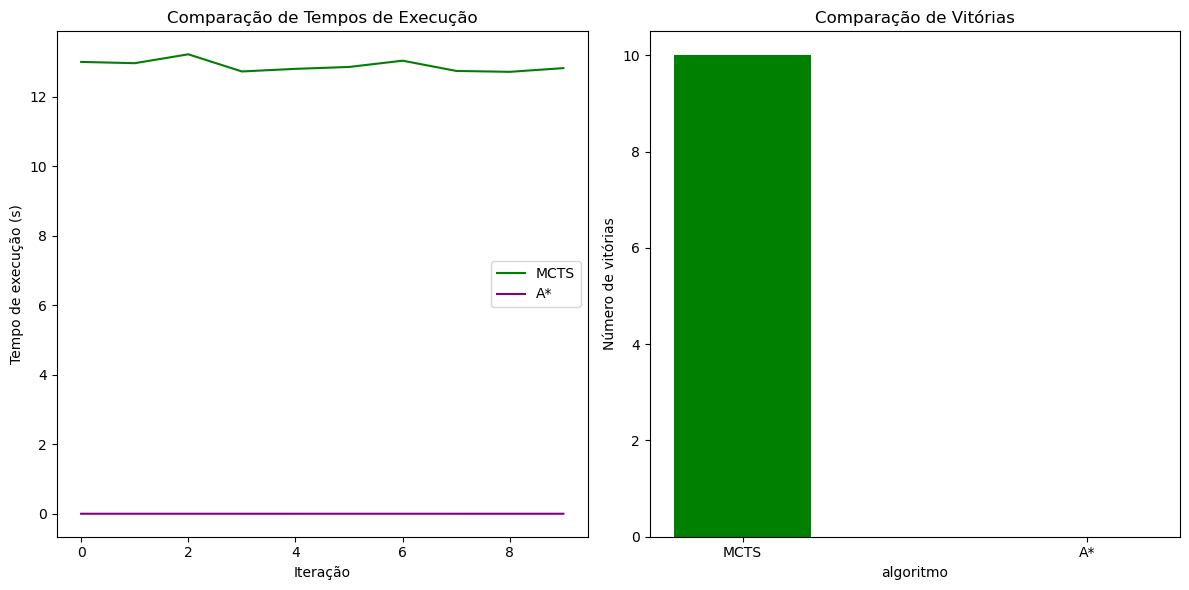

In [21]:
# MCTS VS A*
times_1,times_2,win_1,win_2 = tests('MCTS', 'A*', 10, x1 = 'iterações', x3 = 10000, x4 = 7)


plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times_1, label='MCTS', color='green')
plt.plot(times_2, label='A*', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['MCTS', 'A*'], [int(win_1), int(win_2)], color=['green', 'purple'], width=0.4)
plt.xlabel('algoritmo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

**A Star VS MCTS**

A testar... : 100%|████████████████████████████████████████████████████████████████████| 10/10 [11:52<00:00, 71.29s/it]


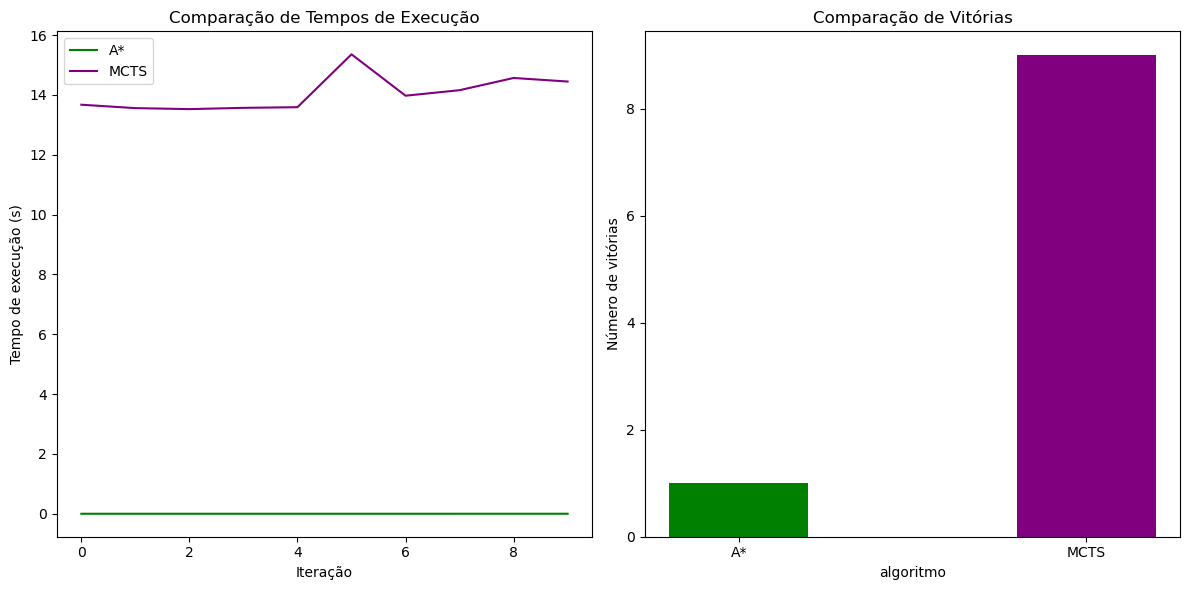

In [22]:
# A* VS MCTS
times_1,times_2,win_1,win_2 = tests('A*', 'MCTS', 10, y1 = 'iterações', y3 = 10000, y4 = 7)


plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times_1, label='A*', color='green')
plt.plot(times_2, label='MCTS', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['A*', 'MCTS'], [int(win_1), int(win_2)], color=['green', 'purple'], width=0.4)
plt.xlabel('algoritmo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

Tal como mencionado previamente, seria de esperar que o MCTS vencesse ao A*. Tal seria fácil de prever uma vez que o A* não tem qualquer tipo de noção adversárial utilizando a Heurística 1, que apenas tem como objetivo determinar a jogada que lhe dá mais pontos. Sendo que os pontos da heurística são atribuidos tendo em conta onde é possivel colocar peças consecutivas seguidas em segmentos de 4, quando o A* encontra um modo de continuar a colocar peças consecutivas, foca-se em continuar a fazer isso, ao invés de bloquear a jogada do adversário que está prestes a vencer.

Contudo, caso se permita que o A* jogue antes que o MCTS pode haver casos em que o MCTS tende a convergir muito cedo para uma solução que pode não ser a melhor, resultando em derrota. Caso este problema não tivesse sido detetado mais cedo e não tivessem sido tomadas medidas para o resolver, poderia haver um maior número de vitórias por parte do A*. As medidas tomadas para contornar esta situação podem ser encontradas em [Monte Carlo Tree Search](#mcts) na parte de solução de problemas.

Por fim, é também facil de reparar que existe uma enorme diferença entre os tempos de execução destes dois algoritmos, no entanto, tal seria de esperar, uma vez que o A* apenas analisa qual a melhor jogada entre as possiveis, que apenas poderão ir até 7. Contráriamente o MCTS faz diversas simulações de jogos para tentar perceber qual a melhor decisão, o que requere muito mais tempo.

[[voltar a  Monte Carlo Tree Search VS A Star]](#mcts_vs_astar)

### Monte Carlo Tree Search VS Minimax <a name = "mcts_vs_minimax"></a>
[[voltar a Testes]](#testes)

Tendo em conta que ao utilizar o Minimax o modo 6 foi o que demonstrou a melhor taxa de sucesso, iremos utilizar esse modo. Para o MCTS mantemos as condições utilizadas no teste anterior.

**MCTS VS Minimax**

A testar... : 100%|███████████████████████████████████████████████████████████████████| 10/10 [28:24<00:00, 170.40s/it]


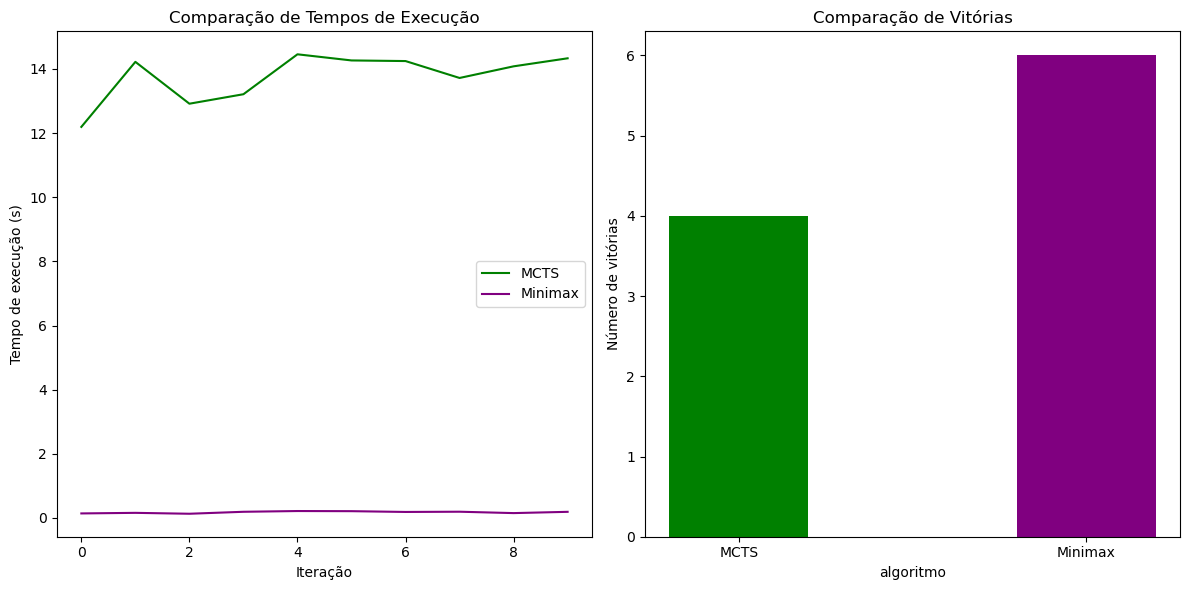

In [23]:
# MCTS VS Minimax
times_1,times_2,win_1,win_2 = tests('MCTS', 'Minimax', 10, x1 = 'iterações', x3 = 10000, x4 = 7, y1 = 6, y2 = 4)


plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times_1, label='MCTS', color='green')
plt.plot(times_2, label='Minimax', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['MCTS', 'Minimax'], [int(win_1), int(win_2)], color=['green', 'purple'], width=0.4)
plt.xlabel('algoritmo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

**Minimax VS MCTS**

A testar... : 100%|█████████████████████████████████████████████████████████████████████| 5/5 [11:49<00:00, 141.88s/it]


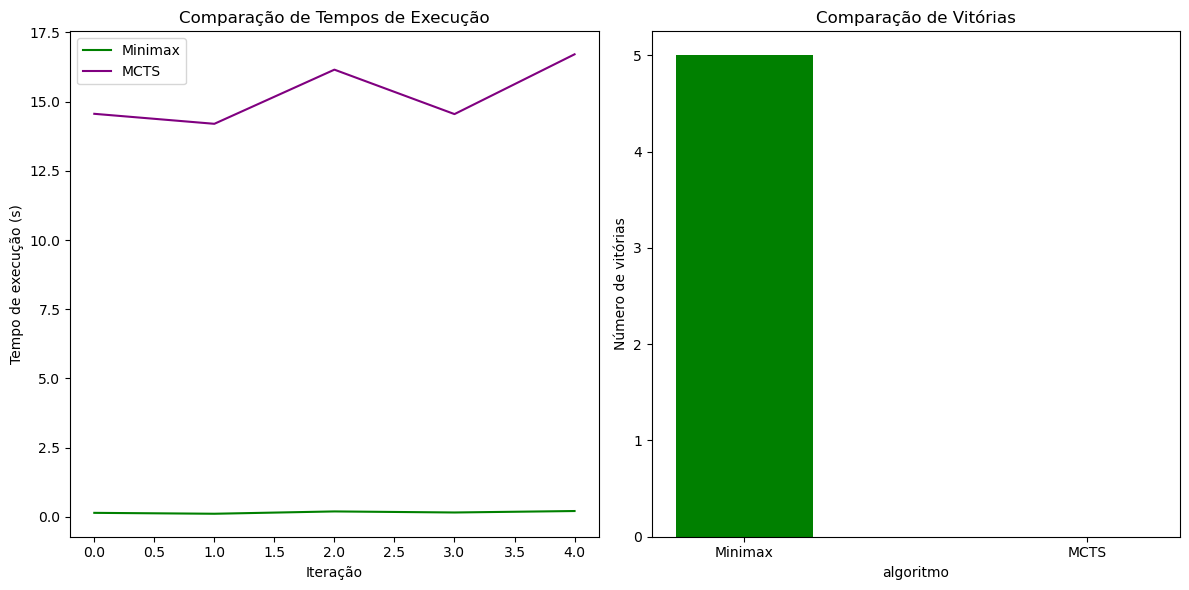

In [24]:
# Minimax VS MCTS
times_1,times_2,win_1,win_2 = tests('Minimax', 'MCTS', 5, y1 = 'iterações', y3 = 10000, y4 = 7, x1 = 6, x2 = 4)


plt.figure(figsize=(12, 6))

# plot para os tempos de execução
plt.subplot(1, 2, 1)
plt.plot(times_1, label='Minimax', color='green')
plt.plot(times_2, label='MCTS', color='purple')
plt.xlabel('Iteração')
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de Tempos de Execução')
plt.legend()

# Gráfico de barras para as vitórias
plt.subplot(1, 2, 2)
plt.bar(['Minimax', 'MCTS'], [int(win_1), int(win_2)], color=['green', 'purple'], width=0.4)
plt.xlabel('algoritmo')
plt.ylabel('Número de vitórias')
plt.title('Comparação de Vitórias')

plt.tight_layout()
plt.show()

A primeira coisa que salta à vista é novamente a enorme diferença de tempos entre um algoritmo e outro, o que seria de esperar porque tal como já foi explicado o MCTS é computacionalmente dispendioso. O facto de se estar a usar pruning no modo utilizado pelo Minimax também permite que haja uma maior diferença de tempos.

Quando o MCTS começa aparenta ter uma maior taxa de sucesso, o que indica que realizar a primeira jogada o favorece. No entanto, nesse teste não é possivel tirar uma conclusão entre qual é o melhor algoritmo já que o vencedor foi bastante disputado. Contudo, quando o Minimax começa não há qualquer dúvida que este é o algoritmo vencedor.

[[voltar a  Monte Carlo Tree Search VS Minimax]](#mcts_vs_minimax)

## Conclusões dos algoritmos <a name = "comp_alg"></a>
[[voltar ao índice]](#indice)

- **A Star :**  No nosso jogo, o objetivo não é encontrar um caminho de um ponto inicial para um ponto final, como em muitos problemas de pesquisa nos grafos. Em vez disso, o objetivo é tomar decisões estratégicas para conseguir ganhar, o que envolve a análise de várias possibilidades de movimentos e previsão das consequências desses movimentos no decorrer do jogo.
   
   Utilizar o algoritmo A* neste contexto não é o mais adequado, pois não é um algoritmo adversarial, logo não vai ter em conta a jogada do adversário quando fizer a sua, mas joga sempre para maximizar a pontuação da peça que coloca. O único modo de contornar este problema seria desenvolver uma heurística capaz de atribuir uma pontuação que considerasse bloquear o adversário e valoriza-se essa ação.
   
   Para além disso, o Connect Four possui um espaço de pesquisa extremamente vasto, especialmente à medida que o jogo progride e mais peças são colocadas no tabuleiro. Isto significa que para o A* que apenas avalia até 7 jogadas possiveis e não tem em conta mais nada, vencer seria uma ínfima hipótese.
  
   Outro aspecto importante é a presença de incerteza e complexidade no Connect Four devido à natureza do jogo e à capacidade do adversário de responder de forma estratégica. Isso dificulta a aplicação eficaz do A*, que pressupõe um conhecimento completo e determinístico do ambiente de pesquisa.

- **Minimax :** Para o Connect Four, o algoritmo Minimax surge como uma escolha ideal devido à capacidade de lidar com as características específicas do jogo e oferece uma abordagem robusta para a tomada de decisões estratégicas, especialmente se considerarmos o uso de poda alpha-beta (melhora muito o tempo de execução do programa).
  
  O Connect Four é um jogo no qual cada movimento deve ser cuidadosamente ponderado, tendo em conta as possíveis respostas do adversário e antecipando as implicações de longo prazo de cada jogada. O algoritmo Minimax é projetado para isso mesmo, explora de forma sistemática todas as possibilidades de movimento até uma certa profundidade na árvore de jogo, e avalia cada uma dessas opções com base na função heurística à escolha. 
  
  Tendo em conta que a heurística 1 está bem definida e as outras duas foram criadas em função da primeira, foi possível implementar um algoritmo minimax versátil e generalizado, capaz de fornecer diferentes níveis de dificuldade (em função da profundidade) e velocidade de execução (análise ao tabuleiro escolhida).

- **Monte Carlo Tree Search :** Podemos concluir que, o MCTS é bastante adequado para o Connect Four devido à sua capacidade de lidar com espaços de pesquisa grandes e complexos e a capacidade de explorar o ambiente através de simulações de jogadas aleatórias. Não é necessário ter um conhecimento completo ou detalhado das regras do jogo ou do ambiente de pesquisa. Em vez disso, o MCTS explora as possibilidades por meio de simulações aleatórias e avaliações estatísticas dos resultados, sem depender de uma análise heurística detalhada ou de um modelo preciso de transição de estados.

     No entanto, o MCTS também apresenta algumas limitações, exigindo um grande número de simulações para alcançar uma solução ótima. Para além disso, restringir o número de nós filhos a que se têm acesso pode prejudicar a qualidade deste algoritmo, principalmente se lhe for dado um número considerávelmente menor daquele que poderia usufruir. Não nos podemos esquecer que encontrar um bom valor para a constante do UCB pode revelar-se um processo demorado, já que são precisos fazer inúmeros testes para encontrar uma boa relação entre a 'exploration' e a 'exploitation'. Contudo, conclui-se que este algoritmo revela ser uma abordagem eficaz para tomar decisões estratégicas.

[[voltar a Conclusões dos algoritmos]](#comp_alg)

## Conclusão<a name = "conclusão"></a>
[[voltar ao índice]](#indice)

Em suma, em comparação com o A* e o MCTS, o Minimax sobressai como a melhor opção para o Connect Four devido à sua natureza adversarial e à sua capacidade de lidar com as estratégias complexas do jogo. Enquanto que o A* não é adequado por não ser um algoritmo adversarial e não considerar as jogadas do adversário, e o MCTS, embora eficaz em explorar espaços de pesquisa grandes e complexos, exige um grande número de simulações para alcançar uma solução ótima, o Minimax oferece uma abordagem direta e eficiente para a tomada de decisões competitivas no Connect Four.